In [1]:
import numpy as np
from torch_geometric.data import Data
import json
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import os
from core.datasetclass import HydrogelNonLinearDataset
from core.model_graphnet_nl import EncodeProcessDecode
import numpy as np
from tqdm import tqdm
from core.utils import * 
import h5py
import meshio
import time
from run_rollout_nl import rollout
device = "cuda"



In [2]:
data_dir = f"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/dataset/nl_dataset"
# data_dir = f"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/testcases/"
# data_dir = f"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/dataset/linear_extr_testcases"
# output_dir = f"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/rollout/{test_on}"
# paraview_dir = f"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/rollout/{test_on}"

time_window = 1
# model_dir = r"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/trained_model/2025-05-30T16h33m36s/model_checkpoint"
model_dir = r"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/trained_model/2025-05-31T12h04m44s/model_checkpoint"
dataset = HydrogelNonLinearDataset(data_dir, add_targets= True, split_frames=True, add_noise = False, time_window=time_window)
data = dataset[49]
model = EncodeProcessDecode(node_feature_size = 5,
                            mesh_edge_feature_size = 7,
                            output_size = 3,
                            latent_size = 128,
                            timestep=1e-5,
                            time_window=time_window,
                            device=device,
                            message_passing_steps = 15)
model.to(device)
model.load_model(model_dir)
model.eval()
model = torch.compile(model)
# Training loop
output = rollout(model, data, time_window)

/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/core/model_graphnet_nl.py:203: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._output_normalizer = 

In [3]:
output.keys()

dict_keys(['mesh_pos', 'node_type', 'cells', 'predict_displacement', 'gt_displacement', 'predict_pvf', 'gt_pvf', 'disp_mse', 'pvf_mse'])

In [4]:
output["gt_displacement"]

[tensor([[-4.2570e-21, -4.2570e-21],
         [ 4.6135e-04, -9.7913e-21],
         [ 9.2270e-04, -5.1085e-21],
         ...,
         [ 1.0614e-02,  1.1539e-02],
         [ 1.1076e-02,  1.1540e-02],
         [ 1.1542e-02,  1.1542e-02]], device='cuda:0'),
 tensor([[[-4.2572e-21, -4.2572e-21],
          [ 4.6135e-04, -9.7916e-21],
          [ 9.2270e-04, -5.1087e-21],
          ...,
          [ 1.0618e-02,  1.1544e-02],
          [ 1.1080e-02,  1.1547e-02],
          [ 1.1551e-02,  1.1551e-02]]], device='cuda:0'),
 tensor([[[-4.2573e-21, -4.2573e-21],
          [ 4.6135e-04, -9.7919e-21],
          [ 9.2270e-04, -5.1090e-21],
          ...,
          [ 1.0621e-02,  1.1550e-02],
          [ 1.1085e-02,  1.1554e-02],
          [ 1.1561e-02,  1.1561e-02]]], device='cuda:0'),
 tensor([[[-4.2574e-21, -4.2574e-21],
          [ 4.6135e-04, -9.7923e-21],
          [ 9.2271e-04, -5.1092e-21],
          ...,
          [ 1.0625e-02,  1.1556e-02],
          [ 1.1090e-02,  1.1561e-02],
          [ 1.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_result(
    mesh_pos: np.array,
    node_connectivity: np.array,
    pred_displacement: np.array,
    gt_displacement: np.array,
    pred_chem_pot: np.array,
    gt_chem_pot: np.array,
    desc: str
):
    """
    Plots predicted vs ground truth displacement fields and chemical potential.

    Parameters:
        mesh_pos (np.array): Node positions (N, 2)
        node_connectivity (np.array): Triangular connectivity (M, 3)
        displacement_pred (np.array): Predicted displacement (N, 2)
        displacement_gt (np.array): Ground truth displacement (N, 2)
        chem_potential (np.array): Scalar chemical potential at nodes (N,)
        desc (str): Description title
    """

    # Create triangulation
    triangulation = tri.Triangulation(mesh_pos[:, 0], mesh_pos[:, 1], node_connectivity)

    # Set up subplots: 3 columns for disp_x, disp_y, chem_potential; 3 rows: pred, gt, error
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fields = ['Displacement X (m)', 'Displacement Y (m)', 'Chemical Potential']
    data_pairs = [
        (pred_displacement[:, 0], gt_displacement[:, 0]),
        (pred_displacement[:, 1], gt_displacement[:, 1]),
        (pred_chem_pot[:,0], gt_chem_pot[:,0])  # chem_potential = pred = gt (no comparison)
    ]
    print(pred_displacement[:, 0].shape)
    for col, (pred_field, gt_field) in enumerate(data_pairs):
        # Row 0: Prediction
        im0 = axes[0, col].tripcolor(triangulation, pred_field, shading='flat', cmap='seismic')
        axes[0, col].triplot(triangulation, color='black', linewidth=0.25)
        axes[0, col].set_title(f"{desc} Prediction - {fields[col]}")
        axes[0, col].set_aspect('equal')
        fig.colorbar(im0, ax=axes[0, col], orientation='vertical')

        # Row 1: Ground Truth
        im1 = axes[1, col].tripcolor(triangulation, gt_field, shading='flat', cmap='seismic')
        axes[1, col].triplot(triangulation, color='black', linewidth=0.25)
        axes[1, col].set_title(f"{desc} Ground Truth - {fields[col]}")
        axes[1, col].set_aspect('equal')
        fig.colorbar(im1, ax=axes[1, col], orientation='vertical')

        # Row 2: Absolute Error
        error_field = pred_field - gt_field
        cmap = 'seismic'  # diverging colormap

        # Center color map at 0
        im2 = axes[2, col].tripcolor(triangulation, error_field, shading='flat', cmap=cmap, vmax = np.max(np.abs(error_field)), vmin = -np.max(np.abs(error_field)))
        axes[2, col].triplot(triangulation, color='black', linewidth=0.25)
        axes[2, col].set_title(f"{desc} Error - {fields[col]}")
        axes[2, col].set_aspect('equal')
        fig.colorbar(im2, ax=axes[2, col], orientation='vertical')

    fig.suptitle(f"{desc} - Field Comparisons", fontsize=18)
    plt.tight_layout()
    plt.show()


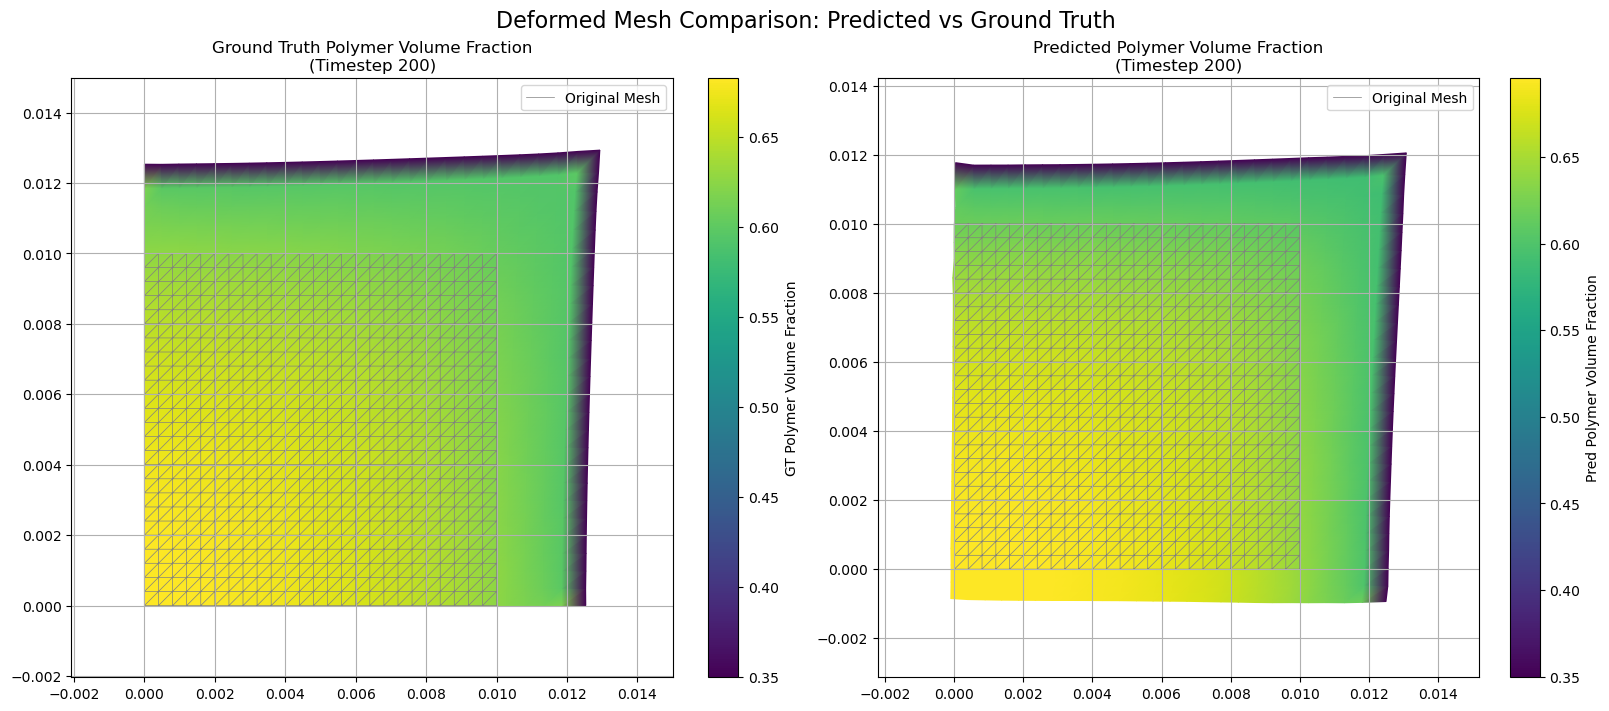

In [8]:
# Setup
timestep = 200
mesh_pos = output["mesh_pos"].detach().cpu().numpy()
cells = output["cells"].detach().cpu().numpy()
pred_displacement = output["predict_displacement"][timestep].squeeze(0).detach().cpu().numpy()
gt_displacement = output["gt_displacement"][timestep].squeeze(0).detach().cpu().numpy()
predict_pvf = output["predict_pvf"][timestep].squeeze(0).detach().cpu().numpy()
gt_pvf = output["gt_pvf"][timestep].squeeze(0).detach().cpu().numpy()

# Deformed positions
deformed_nodes_gt = gt_displacement
deformed_nodes_pred = pred_displacement

# Triangulations
triang_gt = tri.Triangulation(deformed_nodes_gt[:, 0], deformed_nodes_gt[:, 1], cells)
triang_pred = tri.Triangulation(deformed_nodes_pred[:, 0], deformed_nodes_pred[:, 1], cells)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)

# Ground truth
tpc1 = axs[0].tripcolor(triang_gt, gt_pvf.squeeze(), shading='gouraud', cmap='viridis', edgecolors='k', linewidth=0.2)
axs[0].triplot(mesh_pos[:, 0], mesh_pos[:, 1], cells, color='grey', linewidth=0.5, label='Original Mesh')
axs[0].set_title(f'Ground Truth Polymer Volume Fraction\n(Timestep {timestep})')
axs[0].axis('equal')
axs[0].grid(True)
axs[0].legend()
fig.colorbar(tpc1, ax=axs[0], label='GT Polymer Volume Fraction')

# Prediction
tpc2 = axs[1].tripcolor(triang_pred, predict_pvf.squeeze(), shading='gouraud', cmap='viridis', edgecolors='k', linewidth=0.2)
axs[1].triplot(mesh_pos[:, 0], mesh_pos[:, 1], cells, color='grey', linewidth=0.5, label='Original Mesh')
axs[1].set_title(f'Predicted Polymer Volume Fraction\n(Timestep {timestep})')
axs[1].axis('equal')
axs[1].grid(True)
axs[1].legend()
fig.colorbar(tpc2, ax=axs[1], label='Pred Polymer Volume Fraction')

plt.suptitle("Deformed Mesh Comparison: Predicted vs Ground Truth", fontsize=16)
plt.show()

In [48]:
import numpy as np

def compute_grad_u_2d(u, mesh_pos, cells):
    """
    Compute ∇u per triangle using linear shape functions.
    
    Parameters:
        u         : (N, 2) array of nodal displacements
        mesh_pos  : (N, 2) array of original node positions
        cells     : (M, 3) array of triangle vertex indices
    
    Returns:
        grad_u : (M, 2, 2) array of displacement gradients per triangle
    """
    grad_u = np.zeros((cells.shape[0], 2, 2))
    
    for i, tri in enumerate(cells):
        X = mesh_pos[tri]  # (3, 2)
        U = u[tri]         # (3, 2)

        # Build matrix for reference triangle (columns: X1 - X0, X2 - X0)
        DX = np.stack([X[1] - X[0], X[2] - X[0]], axis=1)  # shape (2, 2)
        dU = np.stack([U[1] - U[0], U[2] - U[0]], axis=1)  # shape (2, 2)

        inv_DX = np.linalg.inv(DX)
        grad_u[i] = dU @ inv_DX  # (2,2)

    return grad_u



In [87]:
def µ_(u,φ,X):
    # return variable(µ_o + kBT*(ln(1 - 0.999*φ) + φ + χ*(φ**2)) + (Ω*G0)*(0.999/φ - 0.999*φ)) # <= as in Chester et al. 2010
    grad_u = compute_grad_u_2d(u, mesh_pos, cells)
    J = np.linalg.det(np.eye(2) + grad_u)
    µ_o = 0
    RT = 8.31446261815324*298 
    Ω = 1.7e-28
    K = 100.0e6
    l = J * φ
    print(l.shape)
    return µ_o + RT*(np.log(1 - 0.999*φ) + φ + X*(φ**2)) - (Ω*K)*np.log(J*φ)*φ # <= as in Chester et al. 2011
    # return variable((µ_o) + RT*(ln(1 - 0.999*φ) + φ + χ*(φ**2)) - (Ω*K)*ln(J(u)) + (1/2)*(Ω*K)*ln

In [88]:
timestep = 248
mesh_pos = output["mesh_pos"].detach().cpu().numpy()
cells = output["cells"].detach().cpu().numpy()
pred_displacement = output["predict_displacement"][timestep].squeeze(0).detach().cpu().numpy()
gt_displacement = output["gt_displacement"][timestep].squeeze(0).detach().cpu().numpy()

predict_pvf = output["predict_pvf"][timestep].squeeze(0).detach().cpu().numpy()
pred_chem_pot = µ_(pred_displacement, predict_pvf, data[0]["mat_param_X"][0].numpy())

(676, 1250)


In [80]:
pred_chem_pot.shape

(676, 1250)

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

timestep = 248
mesh_pos = output["mesh_pos"].detach().cpu().numpy()
cells = output["cells"].detach().cpu().numpy()
pred_displacement = output["predict_displacement"][timestep].squeeze(0).detach().cpu().numpy()
gt_displacement = output["gt_displacement"][timestep].squeeze(0).detach().cpu().numpy()

# predict_pvf = output["predict_pvf"][timestep].squeeze(0).detach().cpu().numpy()
predict_pvf = pred_chem_pot



gt_pvf = output["gt_pvf"][timestep].squeeze(0).detach().cpu().numpy()

# Deformed positions
deformed_nodes_gt = gt_displacement
deformed_nodes_pred = pred_displacement

# Triangulations
triang_gt = tri.Triangulation(deformed_nodes_gt[:, 0], deformed_nodes_gt[:, 1], cells)
triang_pred = tri.Triangulation(deformed_nodes_pred[:, 0], deformed_nodes_pred[:, 1], cells)

# Determine shared limits
all_x = np.concatenate([deformed_nodes_gt[:, 0], deformed_nodes_pred[:, 0]])
all_y = np.concatenate([deformed_nodes_gt[:, 1], deformed_nodes_pred[:, 1]])
xlim = (-0.005, 0.02)
ylim = (-0.005, 0.02)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)

# Ground truth
tpc1 = axs[0].tripcolor(triang_gt, gt_pvf.squeeze(), shading='gouraud', cmap='viridis', edgecolors='k', linewidth=0.2)
axs[0].triplot(mesh_pos[:, 0], mesh_pos[:, 1], cells, color='grey', linewidth=0.5, label='Original Mesh')
axs[0].set_title(f'Ground Truth Chemical Potential\n(Timestep {timestep})')
axs[0].axis('equal')
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
axs[0].grid(True)
axs[0].legend()
fig.colorbar(tpc1, ax=axs[0], label='GT Chem. Potential')

# Prediction
tpc2 = axs[1].tripcolor(triang_pred, predict_pvf.squeeze(), shading='gouraud', cmap='viridis', edgecolors='k', linewidth=0.2)
axs[1].triplot(mesh_pos[:, 0], mesh_pos[:, 1], cells, color='grey', linewidth=0.5, label='Original Mesh')
axs[1].set_title(f'Predicted Chemical Potential\n(Timestep {timestep})')
axs[1].axis('equal')
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
axs[1].grid(True)
axs[1].legend()
fig.colorbar(tpc2, ax=axs[1], label='Pred Chem. Potential')

plt.suptitle("Deformed Mesh Comparison: Predicted vs Ground Truth", fontsize=16)
plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


ValueError: Collections can only map rank 1 arrays

<Figure size 1600x700 with 4 Axes>